# Datset: Pairwise approach

Get tracksters from a certain neighbourhood.

Neighbourhood:
- get links from ticlNtuplizer/graph
    - figure out how these links are formed

Graph:
- linked_inners
    - nodes linked to the given tracksters within its cone


In [2]:
import numpy as np
import awkward as ak

from matplotlib.ticker import FormatStrFormatter

from reco.datasetPU import get_event_pairs
from reco.data import get_bary_data, get_event_data

# plotting config
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size': 12})
rc('mathtext',**{'default':'regular'})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

ds_name = "MultiParticle"
file_name = "new_ntuples_15163313_1.root"

ds_name = "CloseByTwoPion"
file_name = "new_ntuples_15101852_0.root"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"
file_path = f"{raw_dir}/{file_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [3]:
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_path)

## Candidate pairs

Compile a list of candidate pairs based on the CLUE3D graph and node distance.

Reject all nodes with above a distance threshold.

In [41]:
eid = 4
dX, dY, _pair_index = get_event_pairs(
    cluster_data,
    trackster_data,
    assoc_data,
    eid,
    10,
    pileup=False,
    bigT_e_th=50,
)


pair_index = np.array(_pair_index)
pos_index = np.array(dY) >= 0.5
neg_index = np.array(dY) < 0.5

# for i, p in  enumerate(_pair_index):
#     print(p, dY[i])

print(sum(pos_index), sum(neg_index))

63 144


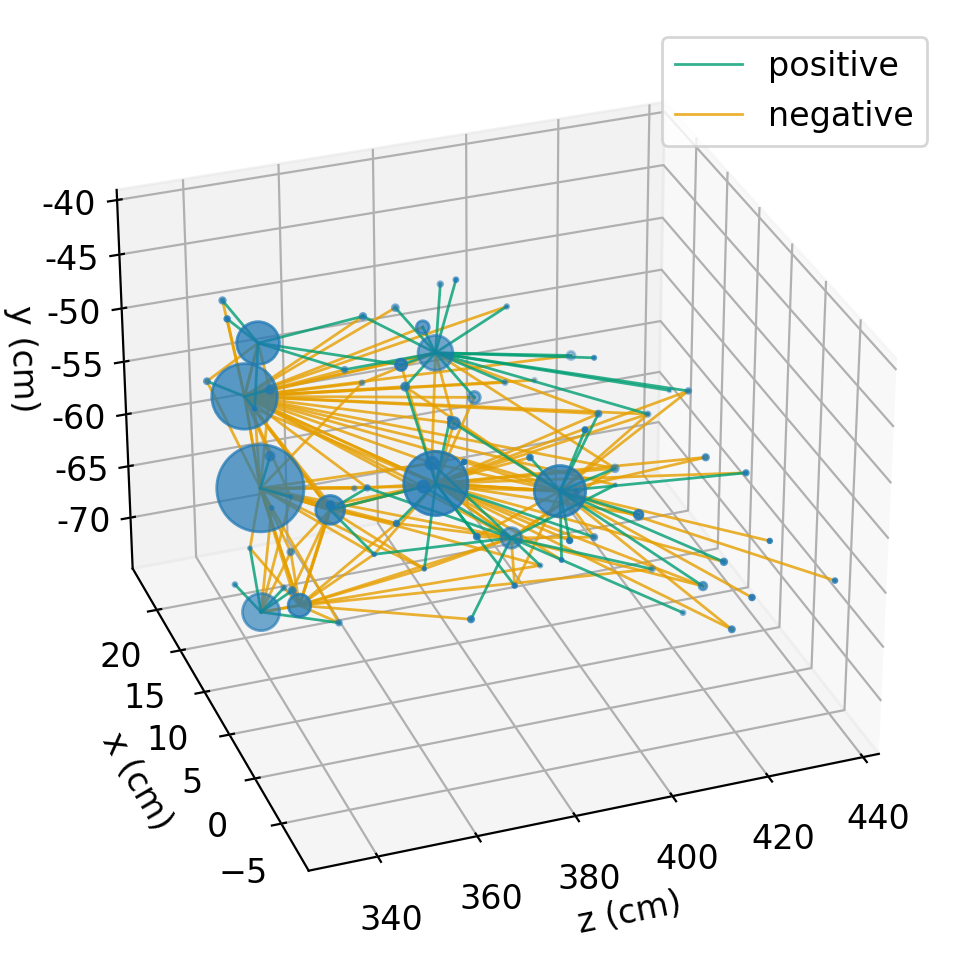

In [42]:
positive = pair_index[pos_index]
negative = pair_index[neg_index]

fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111, projection='3d')

all_tx = list(set(ak.flatten(positive).tolist() + ak.flatten(negative).tolist()))

bary = get_bary_data(trackster_data, eid)
ax1.scatter(bary[:,2][all_tx], bary[:,0][all_tx], bary[:,1][all_tx], s=trackster_data["raw_energy"][eid][all_tx])

pos_edges = []
neg_edges = []

def plot_edge(ax, edge, color, label=None):
    a, b = edge
    ca = bary[a]
    cb = bary[b]
    x = (ca[0], cb[0])
    y = (ca[1], cb[1])
    z = (ca[2], cb[2])
    ax.plot(z, x, y, c=color, linewidth=1, alpha=0.8, label=label) 


plot_edge(ax1, positive[0], "#009E73", "positive")
if len(negative):
    plot_edge(ax1, negative[0], "#E69F00", "negative")
    [plot_edge(ax1, edge, "#E69F00") for edge in negative[1:]]

[plot_edge(ax1, edge, "#009E73") for edge in positive[1:]]

ax1.set_xlabel("z (cm)")
ax1.set_ylabel("x (cm)")
ax1.set_zlabel("y (cm)")
ax1.view_init(elev=30, azim=-110)
# ax1.set_xlim(360, 460)
# ax1.set_ylim(-5, 20)
# ax1.set_zlim(-90, -50)

ax1.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))


plt.legend()

fig.savefig('export/multiparticle-pairwise-edges.pdf', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

## Dataset

In [25]:
from reco.datasetPU import TracksterPairs

In [26]:
# would need to implement some sharding here - roughly 36 files for 1M samples
ds = TracksterPairs(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=10,
    radius=15,
    bigT_e_th=30,
)
ds.y.shape

Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15256267_917.root
Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15256267_956.root
Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15256267_995.root
Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15256267_983.root
Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15163313_4.root
Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15256267_921.root
Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15256267_96.root
Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15256267_976.root
Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15256267_999.root
Processing: /Users/ecuba/data/MultiParticle/new_ntuples_15256267_960.root


torch.Size([512830])

## Dataset balance

- CloseByTwoPion, 10cm radius, 0.7 threshold on 1000 events: 88%
- MultiParticle, 10cm radius, 0.7 threshold on 1000 events: 51% 

In [ ]:
float(sum(ds.y > 0.7) / len(ds.y))

0.5182163715362549

## Dummy evaluation

Let's talk baselines on this dataset. How good is a random guess?
How good is connecting to all nodes in a neighbourhood?

In [3]:
from reco.evaluation import pairwise_model_evaluation
from reco.dummy import DummyPleaser

In [4]:
result = pairwise_model_evaluation(
    cluster_data,
    trackster_data,
    simtrackster_data,
    assoc_data,
    DummyPleaser(),
    decision_th=0.5,
    radius=6,
    max_events=10,
    reco_to_target=False,
    bigT_e_th=30,
)

Event 0:
	clue3d_to_sim:	P: 0.851 R: 0.066 F: 0.585
	target_to_sim:	P: 0.851 R: 0.073 F: 0.605
	reco_to_sim:	P: 0.864 R: 0.093 F: 0.654
Event 1:
	clue3d_to_sim:	P: 0.782 R: 0.067 F: 0.555
	target_to_sim:	P: 0.817 R: 0.186 F: 0.723
	reco_to_sim:	P: 0.808 R: 0.191 F: 0.719
Event 2:
	clue3d_to_sim:	P: 0.928 R: 0.142 F: 0.764
	target_to_sim:	P: 0.929 R: 0.239 F: 0.836
	reco_to_sim:	P: 0.916 R: 0.232 F: 0.823


KeyboardInterrupt: 

## Generating figures

In [ ]:
radius_list = list(range(2, 32, 2))

In [ ]:
clue3D_precision = []
clue3D_recall = []
target_precision = []
target_recall = []
naive_precision = []
naive_recall = []

max_events = 10

for radius in radius_list:
    print("radius:", radius)
    result = pairwise_model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        DummyPleaser(),
        decision_th=0.5,
        radius=radius,
        max_events=max_events,
        reco_to_target=False,
        bigT_e_th=40,
    )
    clue3D = np.array(result["clue3d_to_sim"])
    clue3D_precision.append(np.sum(clue3D[:,0]) / max_events)
    clue3D_recall.append(np.sum(clue3D[:,1]) / max_events)

    target = np.array(result["target_to_sim"])
    target_precision.append(np.sum(target[:,0]) / max_events)
    target_recall.append(np.sum(target[:,1]) / max_events )

    naive = np.array(result["reco_to_sim"])
    naive_precision.append(np.sum(naive[:,0]) / max_events)
    naive_recall.append(np.sum(naive[:,1]) / max_events)

radius: 2
Event 0:
	clue3d_to_sim:	P: 0.851 R: 0.066 F: 0.585
	target_to_sim:	P: 0.851 R: 0.066 F: 0.585
	reco_to_sim:	P: 0.851 R: 0.066 F: 0.585
Event 1:
	clue3d_to_sim:	P: 0.784 R: 0.067 F: 0.555
	target_to_sim:	P: 0.784 R: 0.070 F: 0.563
	reco_to_sim:	P: 0.784 R: 0.070 F: 0.563
Event 2:
	clue3d_to_sim:	P: 0.928 R: 0.142 F: 0.765
	target_to_sim:	P: 0.928 R: 0.142 F: 0.765
	reco_to_sim:	P: 0.928 R: 0.142 F: 0.765
Event 3:
	clue3d_to_sim:	P: 0.824 R: 0.100 F: 0.645
	target_to_sim:	P: 0.824 R: 0.102 F: 0.648
	reco_to_sim:	P: 0.824 R: 0.102 F: 0.648
Event 4:
	clue3d_to_sim:	P: 0.765 R: 0.059 F: 0.524
	target_to_sim:	P: 0.765 R: 0.059 F: 0.524
	reco_to_sim:	P: 0.765 R: 0.059 F: 0.524
Event 5:
	clue3d_to_sim:	P: 0.880 R: 0.095 F: 0.667
	target_to_sim:	P: 0.880 R: 0.095 F: 0.667
	reco_to_sim:	P: 0.880 R: 0.095 F: 0.667
Event 6:
	clue3d_to_sim:	P: 0.836 R: 0.140 F: 0.702
	target_to_sim:	P: 0.828 R: 0.147 F: 0.703
	reco_to_sim:	P: 0.828 R: 0.147 F: 0.703
Event 7:
	clue3d_to_sim:	P: 0.883 R: 0

KeyboardInterrupt: 

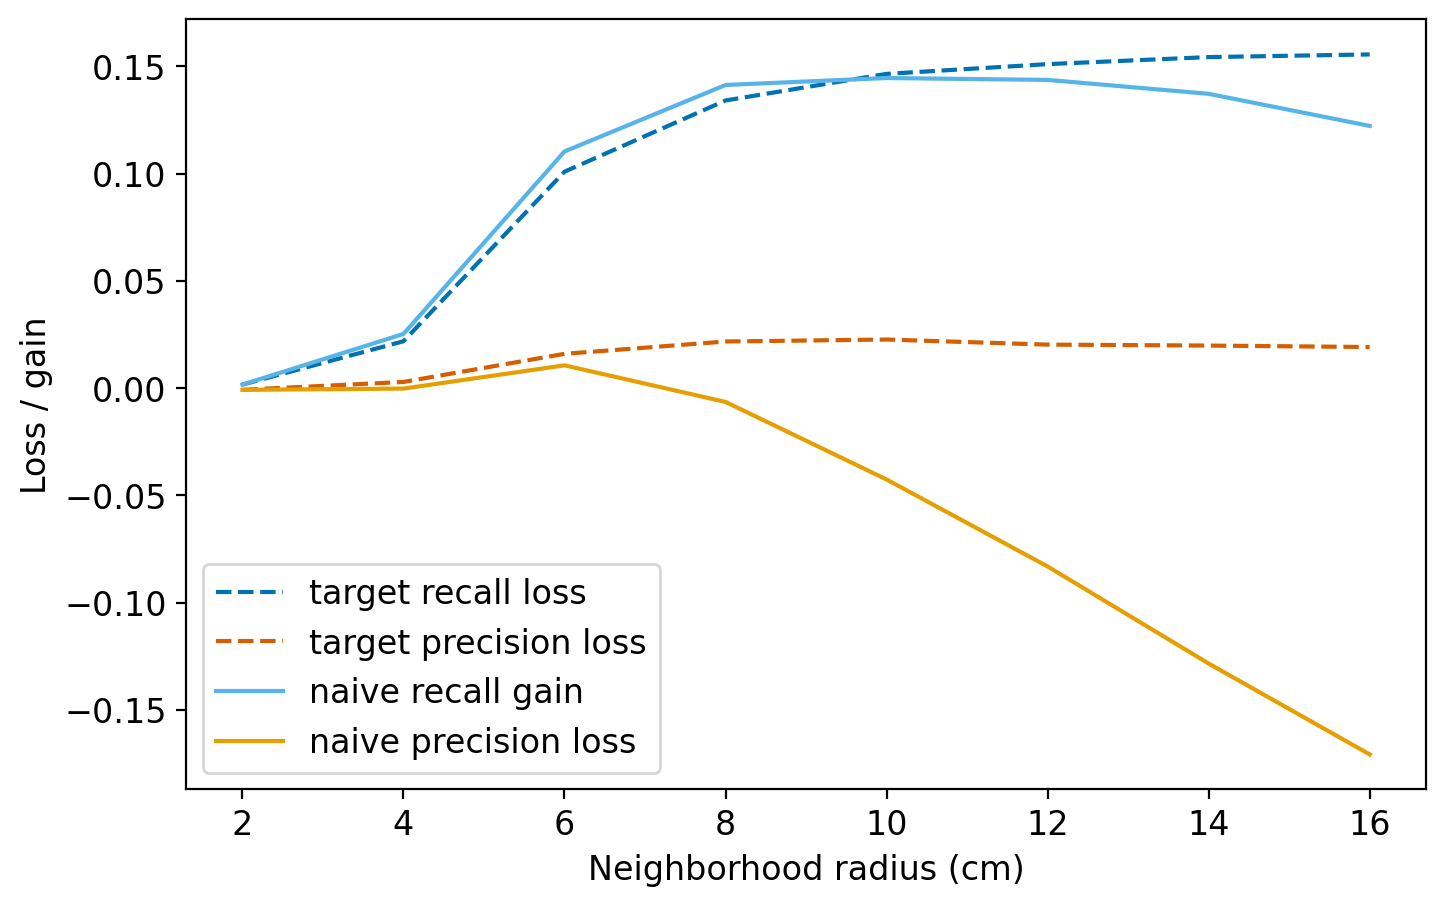

In [ ]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(radius_list[:8], (np.array(target_recall) - np.array(clue3D_recall))[:8], '--', label="target recall loss", c="#0072B2")
ax.plot(radius_list[:8], (np.array(target_precision) - np.array(clue3D_precision))[:8], '--', label="target precision loss", c="#D55E00")

ax.plot(radius_list[:8], (np.array(naive_recall) - np.array(clue3D_recall))[:8], label="naive recall gain", c="#56B4E9")
ax.plot(radius_list[:8], (np.array(naive_precision) - np.array(clue3D_precision))[:8], label="naive precision loss", c="#E69F00")


ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("Loss / gain")

fig.savefig('export/multiparticle-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:

results = {}
energy_list = list(range(10, 105, 5))
max_events = 10

for radius in [10, 20, 30]:
    clue3D_R = []
    target_R = []
    for eng in energy_list:
        print("radius:", radius, "energy:", eng)
        result = pairwise_model_evaluation(
            cluster_data,
            trackster_data,
            simtrackster_data,
            assoc_data,
            DummyPleaser(),
            decision_th=0.5,
            radius=radius,
            max_events=max_events,
            reco_to_target=False,
            bigT_e_th=eng,
        )
        clue3D = np.array(result["clue3d_to_sim"])
        clue3D_R.append(np.sum(clue3D[:,1]) / max_events)

        target = np.array(result["target_to_sim"])
        target_R.append(np.mean(target[:,1]) / max_events)
    results[radius] = (np.array(target_R), np.array(clue3D_R))

radius: 10 energy: 10
Event 0:
	clue3d_to_sim:	P: 0.85 R: 0.07 F: 0.08
	target_to_sim:	P: 0.86 R: 0.11 F: 0.13
	reco_to_sim:	P: 0.86 R: 0.15 F: 0.18
Event 1:
	clue3d_to_sim:	P: 0.78 R: 0.07 F: 0.08
	target_to_sim:	P: 0.82 R: 0.19 F: 0.22
	reco_to_sim:	P: 0.75 R: 0.15 F: 0.18
Event 2:
	clue3d_to_sim:	P: 0.93 R: 0.14 F: 0.17
	target_to_sim:	P: 0.93 R: 0.25 F: 0.30
	reco_to_sim:	P: 0.84 R: 0.23 F: 0.26
Event 3:
	clue3d_to_sim:	P: 0.82 R: 0.10 F: 0.12
	target_to_sim:	P: 0.84 R: 0.29 F: 0.33
	reco_to_sim:	P: 0.76 R: 0.27 F: 0.31
Event 4:
	clue3d_to_sim:	P: 0.77 R: 0.06 F: 0.07
	target_to_sim:	P: 0.79 R: 0.19 F: 0.23
	reco_to_sim:	P: 0.68 R: 0.19 F: 0.22
Event 5:
	clue3d_to_sim:	P: 0.88 R: 0.09 F: 0.12
	target_to_sim:	P: 0.88 R: 0.19 F: 0.22
	reco_to_sim:	P: 0.91 R: 0.21 F: 0.25
Event 6:
	clue3d_to_sim:	P: 0.84 R: 0.14 F: 0.17
	target_to_sim:	P: 0.86 R: 0.36 F: 0.40
	reco_to_sim:	P: 0.75 R: 0.29 F: 0.33
Event 7:
	clue3d_to_sim:	P: 0.88 R: 0.13 F: 0.16
	target_to_sim:	P: 0.90 R: 0.26 F: 0.30


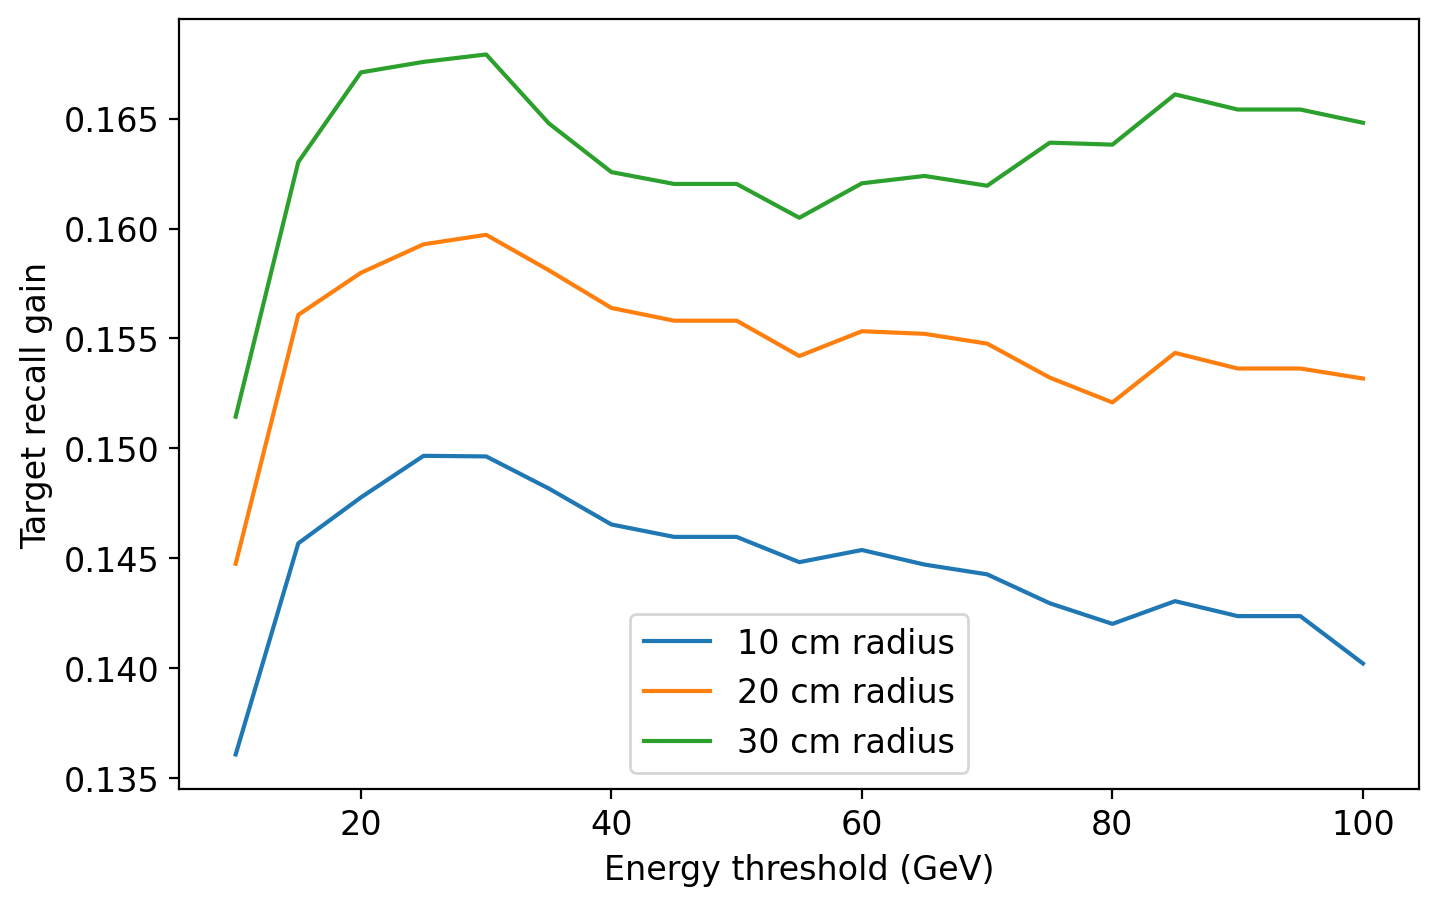

In [ ]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

for k, v in results.items():
    ax.plot(energy_list, v[0] - v[1], label=f"{k} cm radius")

ax.legend()
ax.set_xlabel("Energy threshold (GeV)")
ax.set_ylabel("Target recall gain")

fig.savefig('export/multiparticle-energy-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

# Problems

Sometimes - if a simtrackster is too fragmented, it might not get selected as a big trackster
- we score 0.2 and at least 50% shared energy (or 50GeV)
- if trackster is too fragmented, it might not pass -> then its layerclusters might get stolen
- otherwise: multiple options might pass and then we need to resolve conflicts